In [1]:
library(caret)
library(e1071)
library(randomForest)
library(ROCR)
library(dplyr)
library(tidyr)
library(rpart)
library(gbm)
library(pROC)
library(ggplot2) 
library(kernlab)
library(gridExtra)

Loading required package: ggplot2

Loading required package: lattice

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin



Attaching package: 'dplyr'


The following object is masked from 'package:randomForest':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loaded gbm 2.1.8.1

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var



Attaching package: 'kernlab'


The following object is masked from 'package:ggplot2':

    alpha



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:randomForest':

    combine




In [2]:
# Load the data
data <- read.csv("C:\\Users\\user\\Desktop\\DataProject\\Data\\heart.csv", fileEncoding = "UTF-8") 

# Convert HeartDisease variable
data$HeartDisease <- ifelse(data$HeartDisease == 0, "NoDisease", "HasDisease")
data$HeartDisease <- as.factor(data$HeartDisease)

# Binning continuous variables
continuous_vars <- c("Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak")
continuous_vars_binned <- paste0(continuous_vars, "_binned")

# Adding new categorical columns to the dataframe
for(var in continuous_vars) {
  data[[paste0(var, "_binned")]] <- cut(data[[var]],
                                        breaks = quantile(data[[var]], probs = c(0, 1/3, 2/3, 1), na.rm = TRUE),
                                        labels = c("low", "medium", "high"),
                                        include.lowest = TRUE)
}

# List of categorical variables for dummy variable creation (excluding continuous variables)
predictors <- c("Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", continuous_vars_binned)

# Creation of dummy variables
dummies <- dummyVars(~ ., data = data[, predictors])
data_encoded <- predict(dummies, newdata = data[, predictors])
data_encoded <- as.data.frame(data_encoded) 
data_encoded$HeartDisease <- data$HeartDisease

# Splitting Train/Test data
set.seed(123)
splitIndex <- createDataPartition(data_encoded$HeartDisease, p = 0.8, list = TRUE)
trainData <- data_encoded[splitIndex$Resample1, ]
testData <- data_encoded[-splitIndex$Resample1, ] 


 [1] "ST_SlopeUp.X-squared"          "ST_SlopeFlat.X-squared"       
 [3] "ChestPainTypeASY.X-squared"    "ExerciseAnginaN.X-squared"    
 [5] "ExerciseAnginaY.X-squared"     "ChestPainTypeATA.X-squared"   
 [7] "Oldpeak_binned.high.X-squared" "MaxHR_binned.high.X-squared"  
 [9] "Oldpeak_binned.low.X-squared"  "MaxHR_binned.low.X-squared"   
         ST_SlopeUp.X-squared        ST_SlopeFlat.X-squared 
                    302.02046                     235.98989 
   ChestPainTypeASY.X-squared     ExerciseAnginaN.X-squared 
                    196.14449                     178.84405 
    ExerciseAnginaY.X-squared    ChestPainTypeATA.X-squared 
                    178.84405                     126.97832 
Oldpeak_binned.high.X-squared   MaxHR_binned.high.X-squared 
                    108.57181                      93.23066 
 Oldpeak_binned.low.X-squared    MaxHR_binned.low.X-squared 
                     93.08497                      78.56854 


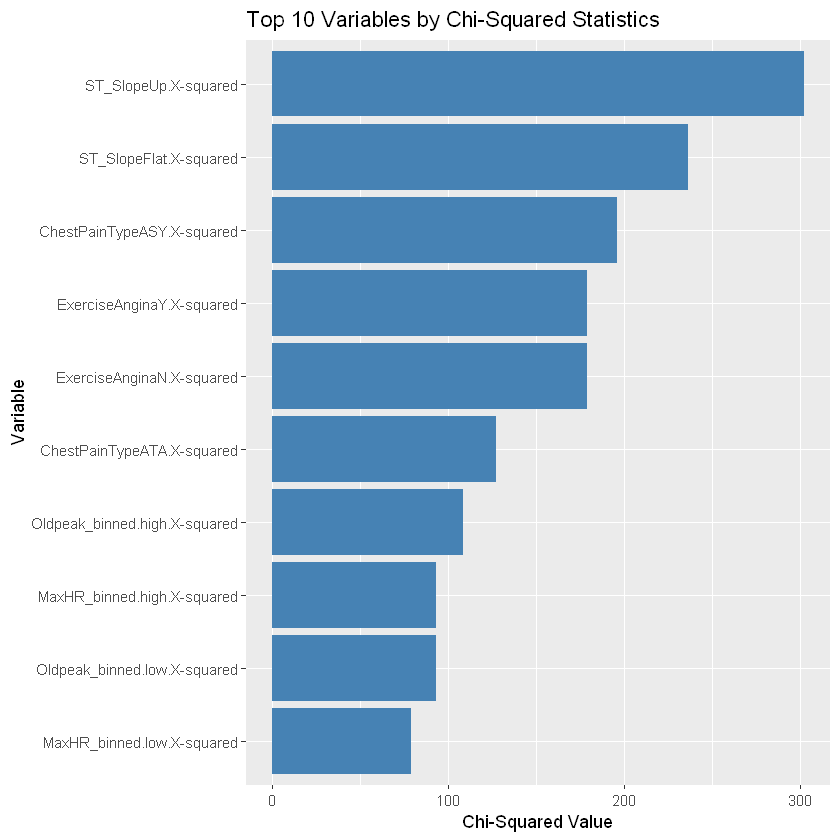

In [3]:
# Function to calculate Chi-Squared test
calculate_chi_squared <- function(variable, data) {
  # Create a contingency table
  table <- table(data[[variable]], data$HeartDisease)
  # Perform Chi-Squared test
  test <- tryCatch({
    chisq.test(table)
  }, warning = function(w) {
    return(NA)
  }, error = function(e) {
    return(NA)
  })
  # Return the Chi-Squared statistic
  if (!is.na(test$statistic)) {
    return(test$statistic)
  } else {
    return(NA)
  }
}

# Perform Chi-Squared test for categorical dummy variables excluding the target variable
chi_squared_values <- sapply(names(trainData)[-which(names(trainData) == "HeartDisease")], function(var) {
  if (is.numeric(trainData[[var]]) && length(unique(trainData[[var]])) == 2) {
    calculate_chi_squared(var, trainData)
  } else {
    NA  # Treat continuous or non-binary categorical variables as NA
  }
}, simplify = "vector")

# Remove NA values
chi_squared_values <- chi_squared_values[!is.na(chi_squared_values)]

# Extract and print the top 10 variables based on Chi-Squared statistics
top_variables <- names(sort(chi_squared_values, decreasing = TRUE)[1:10])
top_chi_squared_values <- sort(chi_squared_values, decreasing = TRUE)[1:10]

print(top_variables)
print(top_chi_squared_values) 

# Visualization of the top 10 variables by Chi-Squared statistics
top_var_chi_sq_data <- data.frame(
  Variable = names(top_chi_squared_values),
  Chi_Squared = top_chi_squared_values
)

ggplot(top_var_chi_sq_data, aes(x = reorder(Variable, Chi_Squared), y = Chi_Squared)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(title = "Top 10 Variables by Chi-Squared Statistics", x = "Variable", y = "Chi-Squared Value") 

                      SexF:RestingBP_binned.low 
                                   3.916501e-02 
                          SexF:MaxHR_binned.low 
                                   1.063356e-02 
                      SexM:RestingBP_binned.low 
                                   3.916501e-02 
                          SexM:MaxHR_binned.low 
                                   1.063356e-02 
                  ChestPainTypeASY:RestingECGST 
                                   1.643670e-02 
                  ChestPainTypeASY:ST_SlopeFlat 
                                   3.377520e-02 
                  ChestPainTypeNAP:RestingECGST 
                                   3.808154e-02 
            ChestPainTypeNAP:Oldpeak_binned.low 
                                   2.380744e-02 
           ChestPainTypeNAP:Oldpeak_binned.high 
                                   3.654063e-02 
                ChestPainTypeTA:ExerciseAnginaN 
                                   3.248843e-02 
                Ches

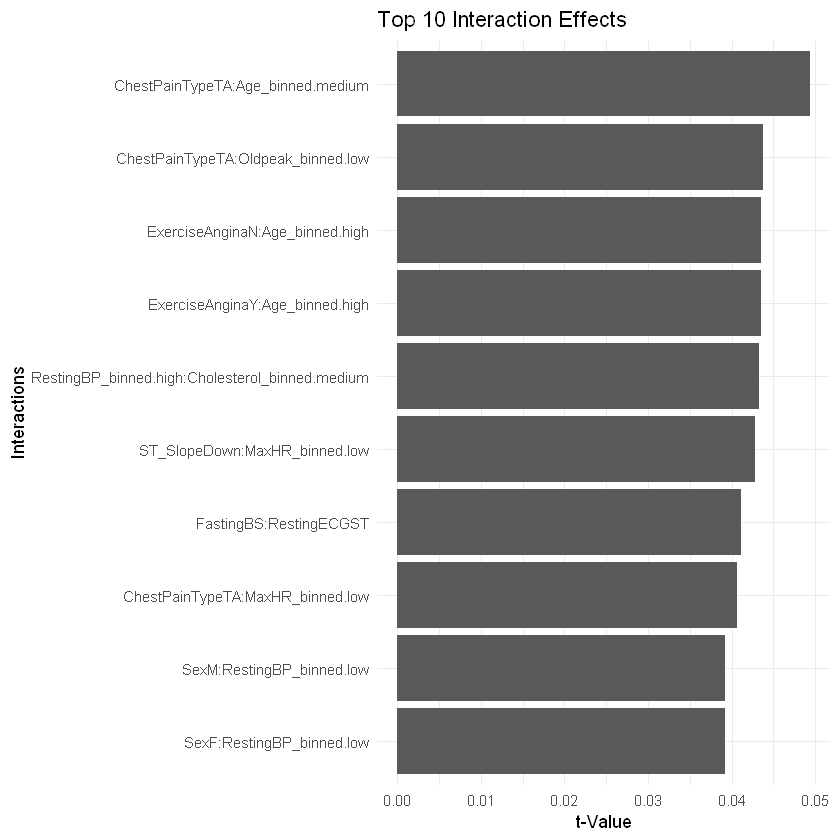

In [4]:
# Generate combinations of all categorical dummy variables
categorical_vars <- names(trainData)[sapply(trainData, function(x) is.numeric(x) && length(unique(x)) == 2)]
all_combinations <- combn(categorical_vars, 2)

# Interactions
interaction_effects_cat <- sapply(1:ncol(all_combinations), function(x) {
  interaction_formula <- as.formula(paste("HeartDisease ~", all_combinations[1, x], "*", all_combinations[2, x]))
  interaction_model <- glm(interaction_formula, data = trainData, family = binomial)
  interaction_term <- paste(all_combinations[1, x], all_combinations[2, x], sep = ":")
  # Check if the interaction term is present in the model summary coefficients
  if (interaction_term %in% rownames(summary(interaction_model)$coefficients)) {
    return(summary(interaction_model)$coefficients[interaction_term, 4])  # t-value for the interaction term
  } else {
    return(NA)  
  } 
}, USE.NAMES = TRUE)
names(interaction_effects_cat) <- apply(all_combinations, 2, function(x) {
  paste(x[1], x[2], sep=":")
})
significant_interactions <- interaction_effects_cat[!is.na(interaction_effects_cat) & interaction_effects_cat < 0.05]
print(significant_interactions)

# Top 10 interactions
top_significant_interactions <- head(significant_interactions[order(abs(significant_interactions), decreasing = TRUE)], 10)

# Dataframe
top_interactions_df <- data.frame(
  Interaction = names(top_significant_interactions),
  tValue = top_significant_interactions
)

# t-value visualization
ggplot(top_interactions_df, aes(x = reorder(Interaction, tValue), y = tValue)) +
  geom_bar(stat = "identity") +
  coord_flip() +  # Flip x and y axes
  labs(title = "Top 10 Interaction Effects", x = "Interactions", y = "t-Value") +
  theme_minimal()


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misl

              (Intercept)                      SexF                      SexM 
              0.417762128               1.974371559                        NA 
         ChestPainTypeASY          ChestPainTypeATA          ChestPainTypeNAP 
             -1.617968602               0.505006902               0.207363587 
          ChestPainTypeTA                 FastingBS             RestingECGLVH 
                       NA              -1.257159212              -0.212757355 
         RestingECGNormal              RestingECGST           ExerciseAnginaN 
             -0.134644409                        NA               1.018256617 
          ExerciseAnginaY              ST_SlopeDown              ST_SlopeFlat 
                       NA              -1.691245068              -2.872004094 
               ST_SlopeUp            Age_binned.low         Age_binned.medium 
                       NA               0.514836115               0.480737398 
          Age_binned.high      RestingBP_binned.low 

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


                    Precision    Recall  F1 Score
Logistic Regression 0.8600000 0.8514851 0.8557214
Decision Tree       0.8131868 0.7326733 0.7708333
k-NN                0.8100000 0.8019802 0.8059701
Random Forest       0.8380952 0.8712871 0.8543689
Gradient Boosting   0.8446602 0.8613861 0.8529412
SVM                 0.8469388 0.8217822 0.8341709


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


                Model       AUC
1 Logistic Regression 0.9071480
2       Decision Tree 0.7483096
3                k-NN 0.8917532
4       Random Forest 0.9052765
5   Gradient Boosting 0.9132456
6                 SVM 0.9077518
Model: Logistic Regression 
glm variable importance

                          Overall
ST_SlopeFlat              100.000
SexF                       63.117
FastingBS                  41.000
ExerciseAnginaN            38.137
ST_SlopeDown               34.645
ChestPainTypeASY           32.830
Oldpeak_binned.medium      25.805
Cholesterol_binned.medium  17.450
Age_binned.medium          16.224
Age_binned.low             15.958
RestingBP_binned.medium    13.300
ChestPainTypeATA            8.852
Oldpeak_binned.low          8.096
RestingECGLVH               5.246
MaxHR_binned.low            4.651
Cholesterol_binned.low      4.424
RestingECGNormal            4.053
ChestPainTypeNAP            3.809
RestingBP_binned.low        3.386
MaxHR_binned.medium         0.000

Model: D

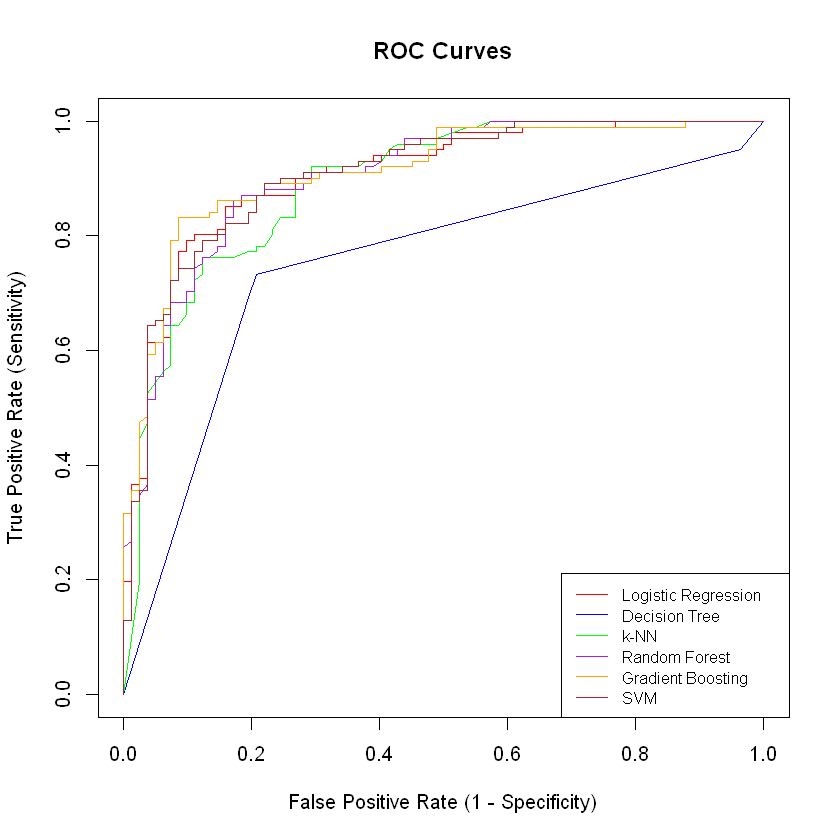

In [5]:
# When using only categorical dummies
ctrl <- trainControl(method = "cv", number = 5, classProbs = TRUE, summaryFunction = twoClassSummary)
models <- list(
  "Logistic Regression" = train(HeartDisease ~ ., data = trainData, method = "glm", trControl = ctrl, metric = "ROC"),
  "Decision Tree" = train(HeartDisease ~ ., data = trainData, method = "rpart", trControl = ctrl, metric = "ROC"),
  "k-NN" = train(HeartDisease ~ ., data = trainData, method = "knn", trControl = ctrl, metric = "ROC"),
  "Random Forest" = train(HeartDisease ~ ., data = trainData, method = "rf", trControl = ctrl, metric = "ROC"),
  "Gradient Boosting" = train(HeartDisease ~ ., data = trainData, method = "gbm", trControl = ctrl, metric = "ROC", verbose = FALSE),
  "SVM" = train(HeartDisease ~ ., data = trainData, method = "svmRadial", trControl = ctrl, metric = "ROC")
)
logistic_model_all_coef <- coef(models$'Logistic Regression'$finalModel)
print(logistic_model_all_coef)
cat("\nLogistic Regression Coefficients (All Variables):\n")
print(logistic_model_all_coef)
metrics <- lapply(models, function(model) {
  prediction <- predict(model, newdata = testData, type = "raw")
  cm <- confusionMatrix(prediction, reference = testData$HeartDisease)
  precision <- cm$byClass['Pos Pred Value']
  recall <- cm$byClass['Sensitivity']
  f1 <- 2 * (precision * recall) / (precision + recall)
  c(Precision = precision, Recall = recall, `F1 Score` = f1)
})
metrics_df <- as.data.frame(do.call(rbind, metrics))
rownames(metrics_df) <- names(models)
colnames(metrics_df) <- c("Precision", "Recall", "F1 Score")
print(metrics_df)
plot_colors <- c("red", "blue", "green", "purple", "orange", "brown")
auc_values <- numeric(length(models))
for(i in seq_along(models)) {
  model <- models[[i]]
  prob <- predict(model, newdata = testData, type = "prob")
  roc_curve <- roc(response=testData$HeartDisease, predictor=prob[,2], levels=c("NoDisease", "HasDisease"), direction=">")
  auc_values[i] <- auc(roc_curve)
  x <- 1 - roc_curve$specificities
  y <- roc_curve$sensitivities
  if(i == 1) {
    plot(x, y, type="l", col=plot_colors[i], xlim=c(0,1), ylim=c(0,1), xlab="False Positive Rate (1 - Specificity)", ylab="True Positive Rate (Sensitivity)", main="ROC Curves")
  } else {
    lines(x, y, col=plot_colors[i])
  }
}
legend("bottomright", legend=names(models), col=plot_colors, lty=1, cex=0.8)
auc_df <- data.frame(Model = names(models), AUC = auc_values)
print(auc_df)
for(model_name in names(models)) {
  model <- models[[model_name]]
  cat("Model:", model_name, "\n")
  if(methods::is(model, "train")) {
    importance <- varImp(model)
    print(importance)
  } else {
    cat("Variable importance not available for this model.\n")
  }
  cat("\n")
}


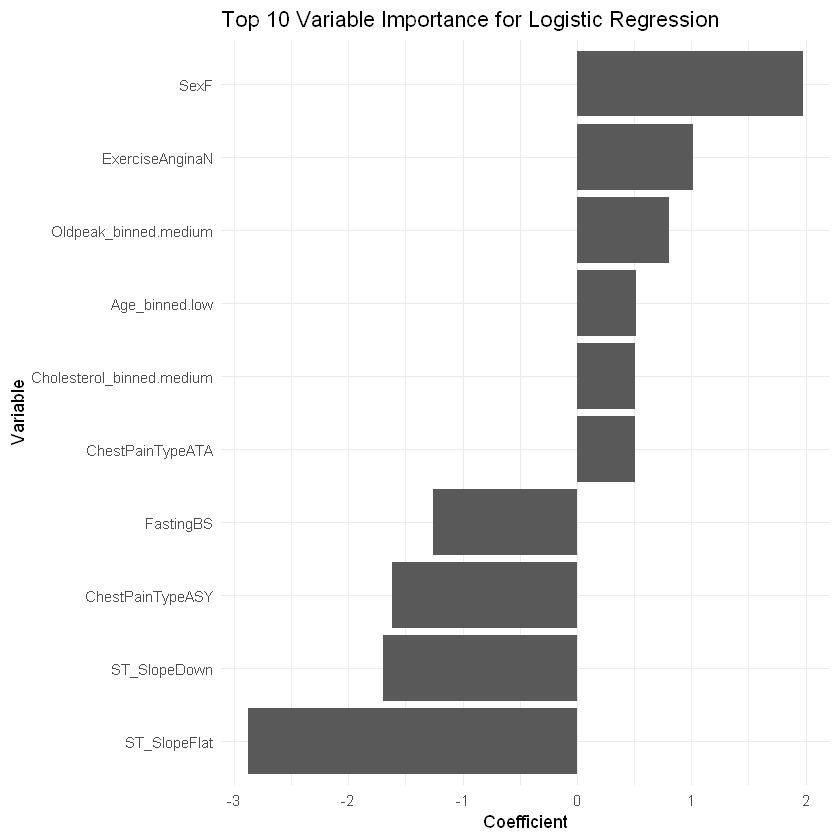

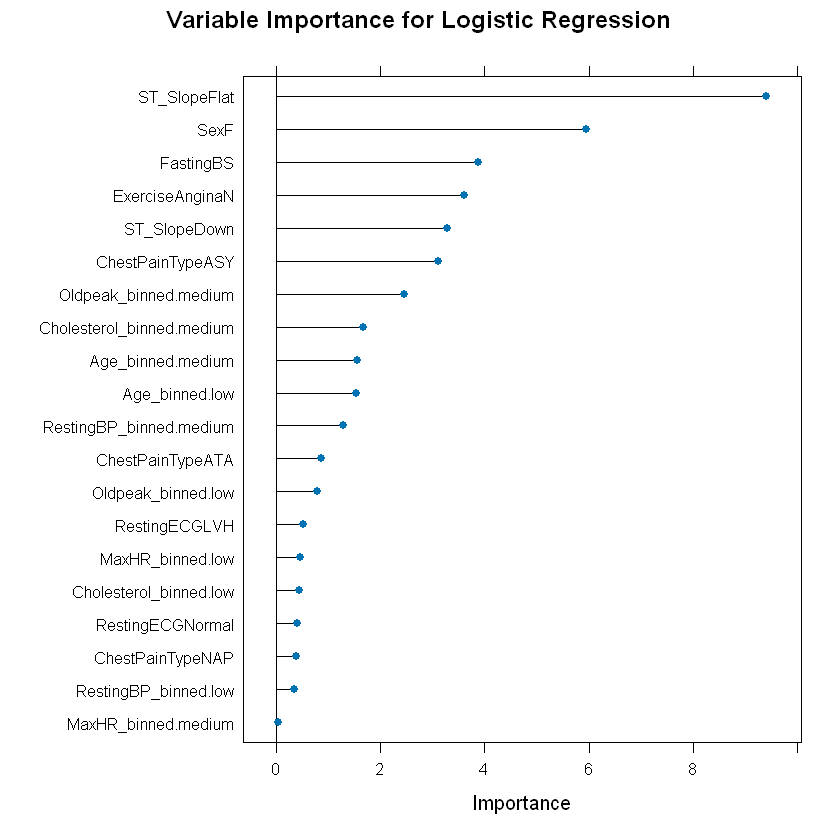

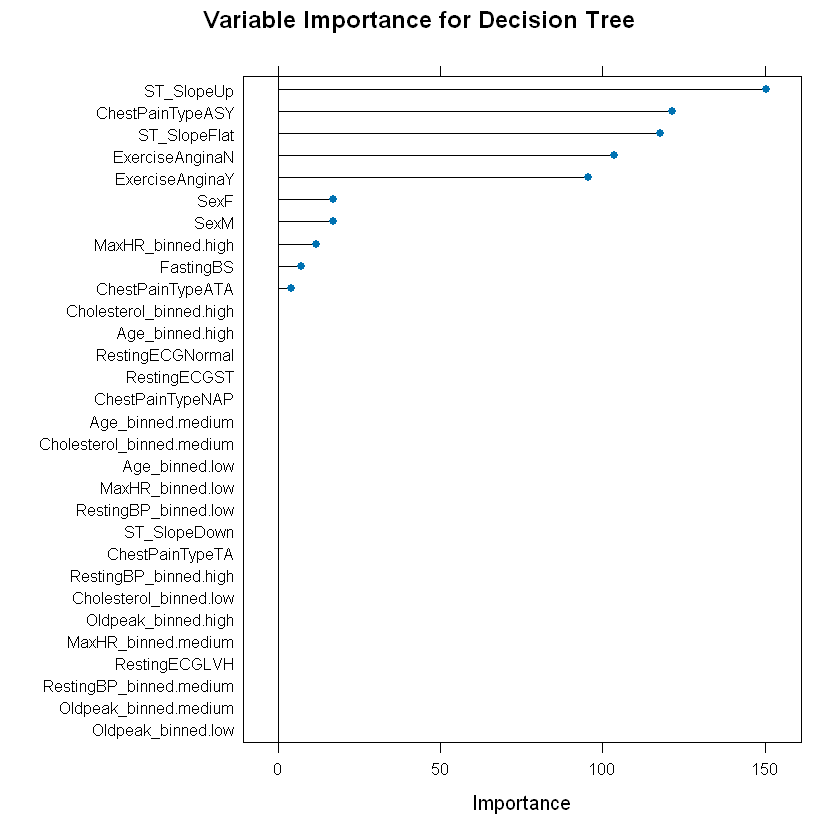

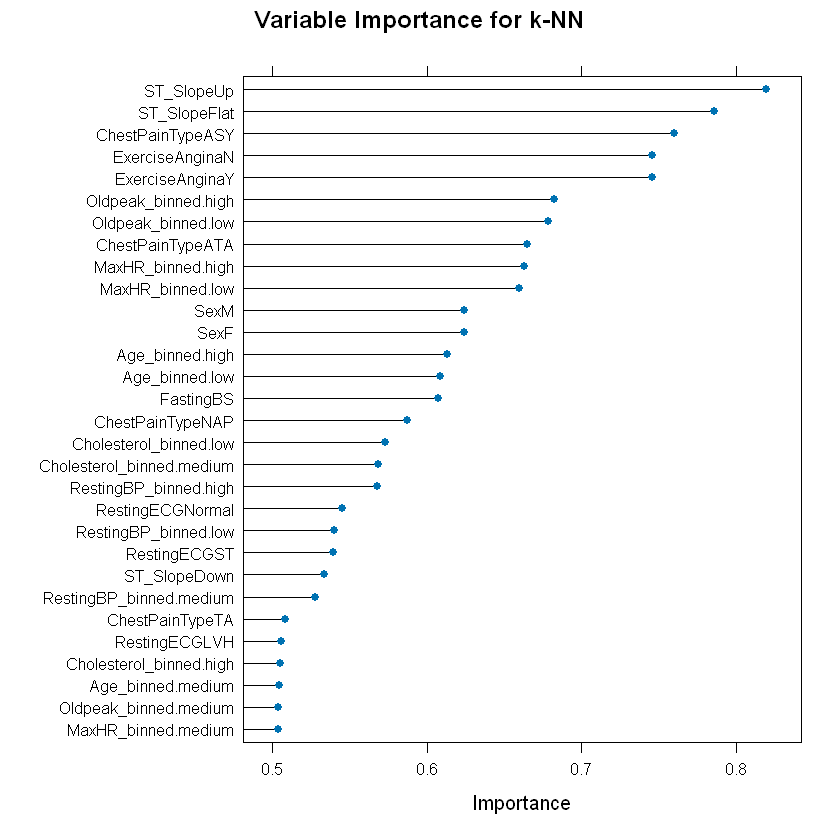

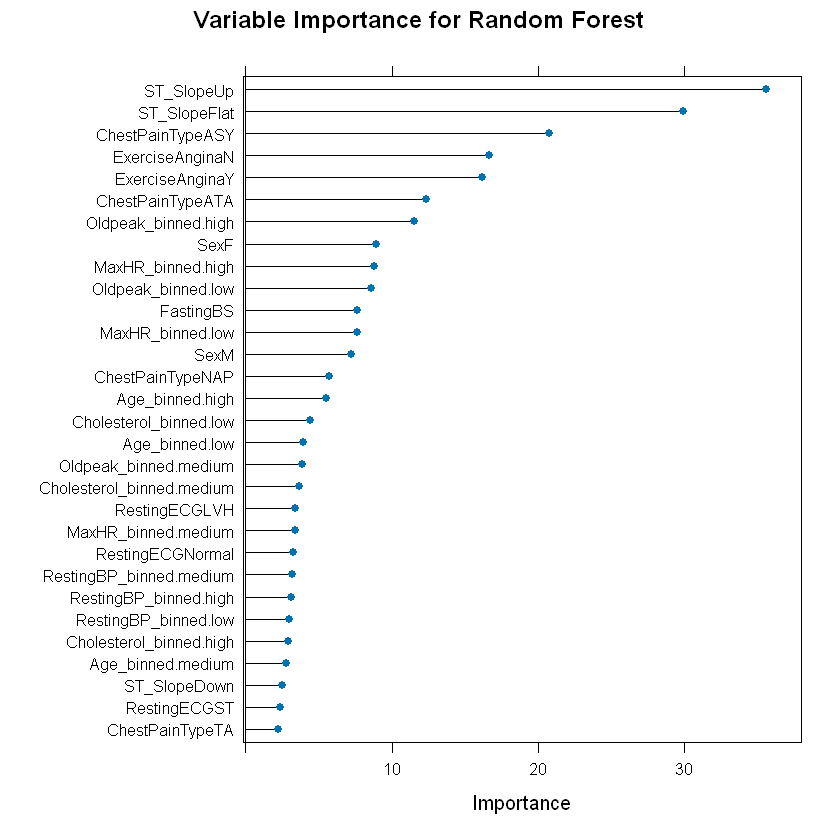

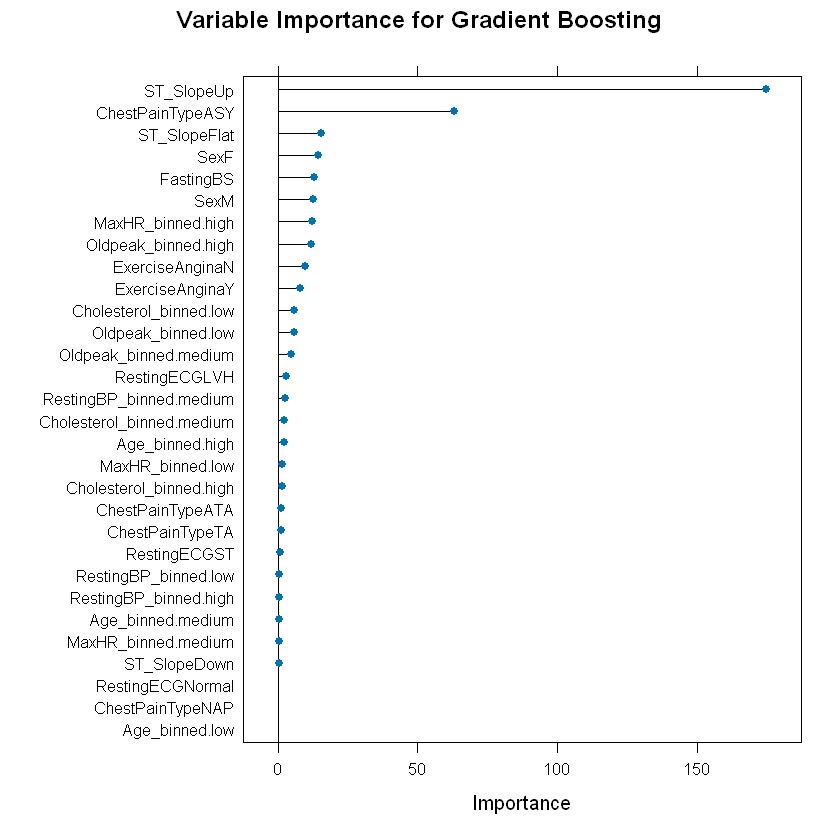

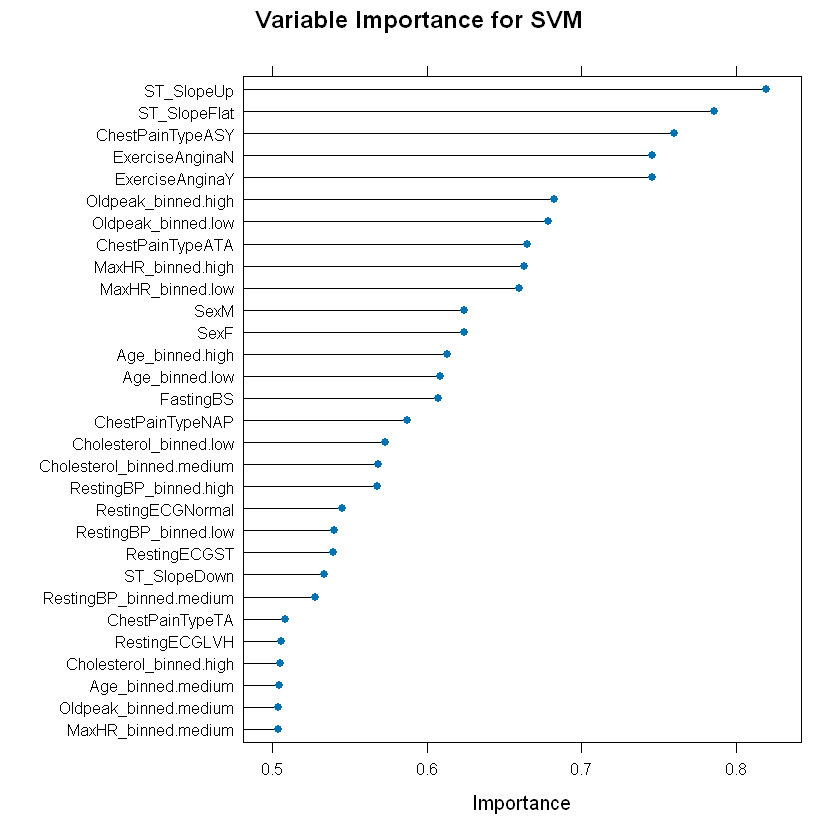

In [6]:
# Logistic Regression 
logistic_importance <- coef(models$'Logistic Regression'$finalModel)
importance_df <- data.frame(
  Variable = names(logistic_importance),
  Coefficient = unname(logistic_importance)
)
top_variables <- importance_df %>%
  arrange(desc(abs(Coefficient))) %>%
  head(10)
ggplot(top_variables, aes(x = reorder(Variable, Coefficient), y = Coefficient)) +
  geom_bar(stat = "identity") + 
  coord_flip() +  
  theme_minimal() + 
  xlab("Variable") + 
  ylab("Coefficient") + 
  ggtitle("Top 10 Variable Importance for Logistic Regression") 

# Logistic Regression 
Logistic_Regression_importance <- varImp(models$'Logistic Regression', scale = FALSE)
plot(Logistic_Regression_importance, main = "Variable Importance for Logistic Regression")

# Decision Tree 
tree_importance <- varImp(models$'Decision Tree', scale = FALSE)
plot(tree_importance, main = "Variable Importance for Decision Tree")

# k-NN 
knn_importance <- varImp(models$'k-NN', scale = FALSE)
plot(knn_importance, main = "Variable Importance for k-NN")

# Random Forest 
rf_importance <- varImp(models$'Random Forest', scale = FALSE)
plot(rf_importance, main = "Variable Importance for Random Forest") 

# Gradient Boosting 
gbm_importance <- varImp(models$'Gradient Boosting', scale = FALSE)
plot(gbm_importance, main = "Variable Importance for Gradient Boosting")

# SVM 
svm_importance <- varImp(models$'SVM', scale = FALSE)
plot(svm_importance, main = "Variable Importance for SVM") 
